## EXPERIMENT 1: MagFace

In [1]:
## Load libraries

import numpy as np
import cv2
from matplotlib import pyplot as plt
import torch
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize
import sys
sns.set(style="white")
%matplotlib inline
sys.path.append('../../utils')
from Model_utils.Model_funcs import *
from Result_metric_utils.result_metrics import *
from Data_proc_utils.Data_proc_funcs import *
from DET_utils.DET_plots import *
from DET_utils.DET import *

from IPython import embed


### MagFace Results

This notebook loads the feature vectors from MagFace and run them through the results metrics:
FNIR, FPIR, FND, FPD, and GARBE

### Load data

In [ ]:
# # Get all features from feature lists from magface model
# feature_list_children = '../../data/raw_full/feat_img_children_full.list'
# feature_list_adults = '../../data/raw_full/feat_img_adults_full.list'

# image_names_c, ids_c, num_ids_c, norm_feats_c = load_magface_vectors(feature_list_children)
# image_names_a, ids_a, num_ids_a, norm_feats_a = load_magface_vectors(feature_list_adults)

# # Similarity matrices from magface - all
# sim_mat_c = np.dot(norm_feats_c, norm_feats_c.T)
# sim_mat_a = np.dot(norm_feats_a, norm_feats_a.T)

# # Dataframes with info, removes names not in magface results
# children_all = pd.read_csv('../../data/image_info_csvs/final_filtered_children_df_BIBEL.csv') #erstat med den opdaterede
# children_all = children_all[children_all.image_name.isin(image_names_c)]
# adults_all = pd.read_csv('../../data/image_info_csvs/final_filtered_adults_df_BIBEL.csv') #erstat med den opdaterede
# adults_all = adults_all[adults_all.image_name.isin(image_names_a)] # OBS, this operation because some magface images has not been through all adults images.


In [ ]:
feature_list_children = '../../data/data_full/feature_vectors/magface_feature_vectors/feat_img_children_full.list'
feature_list_adults = '../../data/data_full/feature_vectors/magface_feature_vectors/feature_vectors_from_adults_bibel_cropped.list'


def load_and_compute_similarity(feature_list, dtype=np.float32):
    # Load data
    image_names, ids, num_ids, norm_feats = load_magface_vectors(feature_list)

    # Convert dtype to reduce memory usage
    norm_feats = norm_feats.astype(dtype)

    # Compute similarity matrix incrementally if possible
    sim_mat = np.dot(norm_feats, norm_feats.T)

    return image_names, ids, num_ids, sim_mat


In [ ]:
# Load and compute for children
image_names_c, ids_c, num_ids_c, sim_mat_c = load_and_compute_similarity(feature_list_children)


In [ ]:

# Load and compute for adults
image_names_a, ids_a, num_ids_a, sim_mat_a = load_and_compute_similarity(feature_list_adults)


In [ ]:


# Dataframes with info, removes names not in magface results
children_all = pd.read_csv('../../data/image_info_csvs/final_filtered_children_df_BIBEL.csv')
children_all = children_all[children_all.image_name.isin(image_names_c)]

adults_all_org = pd.read_csv('../../data/image_info_csvs/final_filtered_adults_df_BIBEL.csv')
adults_all = adults_all_org[adults_all_org.image_name.isin(image_names_a)]

In [ ]:
her = 1
image_names_a[her], ids_a[her], num_ids_a[her]

### GET METRICS 10 TIMES

In [ ]:
random_states = [1,2,3,4,5,6,7,8,9,10]
sim_mat_dict_all_magface_ex1_1 = {}
FNIR_c_list=[]
FNIR_a_list=[]
FPIR_c_list=[]
FPIR_a_list=[]
FPD_list=[]
FND_list=[]
GARBE_list=[]
threshold_list = []

for random_state_i in random_states:

    ### Load children and adults balanced data ###
    children_balanced_df_i = balance_child_data(children_all, print_stats=False, random_state=random_state_i)
    adults_balanced_df_i = balance_adults_data_enrolled(children_balanced_df_i, adults_all, print_stats=False, random_state=random_state_i)



    ### All reference image names, enrolled and non-enrolled image names - children ###
    c_mates = children_balanced_df_i.groupby("identity_name").agg({'identity_name': ['count']})
    enrolled_identity_names_c = c_mates[c_mates[('identity_name', 'count')] > 1].index
    enrolled_image_names_c = list(children_balanced_df_i[children_balanced_df_i["identity_name"].isin(enrolled_identity_names_c)].image_name)
    non_enrolled_identity_names_c = c_mates[c_mates[('identity_name', 'count')] == 1].index
    non_enrolled_image_names_c = list(children_balanced_df_i[children_balanced_df_i["identity_name"].isin(non_enrolled_identity_names_c)].image_name)
    all_reference_image_names_c = list(children_balanced_df_i.image_name)


    ### All reference image names, enrolled and non-enrolled image names - adults ###
    a_mates = adults_balanced_df_i.groupby("identity_name").agg({'identity_name': ['count']})
    enrolled_identity_names_a = a_mates[a_mates[('identity_name', 'count')] > 1].index
    enrolled_image_names_a = list(adults_balanced_df_i[adults_balanced_df_i["identity_name"].isin(enrolled_identity_names_a)].image_name)
    non_enrolled_identity_names_a = a_mates[a_mates[('identity_name', 'count')] == 1].index
    non_enrolled_image_names_a = list(adults_balanced_df_i[adults_balanced_df_i["identity_name"].isin(non_enrolled_identity_names_a)].image_name)
    all_reference_image_names_a = list(adults_balanced_df_i.image_name)



    ### Similarity matrices for ids in reference database ###
    indices_c_all_reference = [image_names_c.index(name) for name in all_reference_image_names_c]
    indices_a_all_reference = [image_names_a.index(name) for name in all_reference_image_names_a]



    # Extract corresponding columns from the similarity matrix
    sim_mat_c_reference_cols = sim_mat_c[:, indices_c_all_reference]


    sim_mat_a_reference_cols = sim_mat_a[:, indices_a_all_reference]

    # Extract corresponding rows from the numerical ids
    num_ids_c_reference = num_ids_c[indices_c_all_reference]
    num_ids_a_reference = num_ids_a[indices_a_all_reference]


    ### Similarity matrices for non-enrolled ids ###
    # Get indices of all feature and numerical id elements that are non-enrolled  ids
    indices_c_non_enrolled = [image_names_c.index(name) for name in non_enrolled_image_names_c]
    indices_a_non_enrolled = [image_names_a.index(name) for name in non_enrolled_image_names_a]


    # Extract corresponding rows from the similarity matrix
    sim_mat_c_non_enrolled_0 = sim_mat_c_reference_cols[indices_c_non_enrolled]
    sim_mat_a_non_enrolled_0 = sim_mat_a_reference_cols[indices_a_non_enrolled]

    # Extract corresponding rows from the numerical ids
    num_ids_c_non_enrolled = num_ids_c[indices_c_non_enrolled]
    num_ids_a_non_enrolled = num_ids_a[indices_a_non_enrolled]


    ### Similarity matrices for enrolled ids ###
    # Get indices of all feature and numerical id elements that are enrolled ids
    indices_c_enrolled = [image_names_c.index(name) for name in enrolled_image_names_c]
    indices_a_enrolled = [image_names_a.index(name) for name in enrolled_image_names_a]

    # Extract corresponding rows from the similarity matrix
    sim_mat_c_enrolled_0 = sim_mat_c[np.ix_(indices_c_enrolled, indices_c_enrolled)] # only enrolled columns and rows
    sim_mat_a_enrolled_0 = sim_mat_a[np.ix_(indices_a_enrolled, indices_a_enrolled)]

    # Extract corresponding rows from the numerical ids
    num_ids_c_enrolled = num_ids_c[indices_c_enrolled]
    num_ids_a_enrolled = num_ids_a[indices_a_enrolled]


    ### DET THINGS ###

    # thold = (np.percentile(sim_mat_c,90)+np.percentile(sim_mat_a,90))/2
    # thold = ((np.percentile(sim_mat_c_non_enrolled_0,90) + (np.percentile(sim_mat_a_non_enrolled_0,90)))/2 + (np.percentile(sim_mat_c_enrolled_0,90) + (np.percentile(sim_mat_a_enrolled_0,90)))/2 )/2
    # thold = np.percentile(sim_mat_a, 99)
    thold = 0.31

    ### Evaluation metrics ###
    # FNIR
    FNIR_c, sim_mat_c_enrolled = compute_fnir(sim_mat_c_enrolled_0, sim_mat_c, enrolled_identity_names_c, num_ids_c_enrolled, ids_c, thold=thold)
    FNIR_a, sim_mat_a_enrolled = compute_fnir(sim_mat_a_enrolled_0, sim_mat_a, enrolled_identity_names_a, num_ids_a_enrolled, ids_a, thold=thold)
    # FPIR
    FPIR_c = compute_fpir(sim_mat_c_non_enrolled_0, num_ids_c_non_enrolled, num_ids_c_reference, thold=thold)
    FPIR_a = compute_fpir(sim_mat_a_non_enrolled_0, num_ids_a_non_enrolled, num_ids_a_reference, thold=thold)




    # OBS maybe compute Garbe outside funtion to choose a good alpha?
    alpha_garbe = 0.25
    FPD_i, FND_i, GARBE_i = GARBE(FNIR_c, FNIR_a, FPIR_c, FPIR_a, alpha=alpha_garbe)


    FNIR_c_list.append(FNIR_c)
    FNIR_a_list.append(FNIR_a)
    FPIR_c_list.append(FPIR_c)
    FPIR_a_list.append(FPIR_a)
    FPD_list.append(FPD_i)
    FND_list.append(FND_i)
    GARBE_list.append(GARBE_i)
    threshold_list.append(thold)

    sim_mat_dict_all_magface_ex1_1['sim_mat_c_enrolled_iteration_{}'.format(random_state_i)]=sim_mat_c_enrolled
    sim_mat_dict_all_magface_ex1_1['sim_mat_a_enrolled_iteration_{}'.format(random_state_i)]=sim_mat_a_enrolled
    sim_mat_dict_all_magface_ex1_1['sim_mat_c_non_enrolled_iteration_{}'.format(random_state_i)]=remove_ones(sim_mat_c_non_enrolled_0)
    sim_mat_dict_all_magface_ex1_1['sim_mat_a_non_enrolled_iteration_{}'.format(random_state_i)]=remove_ones(sim_mat_a_non_enrolled_0)


    print("done")

data = {
    'Iteration': random_states,
    'FNIR_c': FNIR_c_list,
    'FNIR_a': FNIR_a_list,
    'FPIR_c': FPIR_c_list,
    'FPIR_a': FPIR_a_list,
    'FPD': FPD_list,
    'FND': FND_list,
    'GARBE': GARBE_list,
    'Threshold': threshold_list
}
df_all_results = pd.DataFrame(data)


In [ ]:
df_all_results.to_csv('results_10_experiment_1_1_magface.csv')

In [ ]:
# import csv
# with open("sim_mat_dict_all_magface_ex1_1.csv", "w", newline="") as f:
#     w = csv.DictWriter(f, sim_mat_dict_all_magface_ex1_1.keys())
#     w.writeheader()
#     w.writerow(sim_mat_dict_all_magface_ex1_1)

In [ ]:
# Add together all

# make one  big array out of all arays named f'sim_mat_dict_all_magface_ex1_1['sim_mat_c_enrolled_iteration_{i}']' for i from 1 to 10
# List to hold all the arrays
sim_mat_c_enrolled_iterations = []

# Loop to access each array and append it to the list
for i in range(1, 11):
    key = f'sim_mat_c_enrolled_iteration_{i}'
    if key in sim_mat_dict_all_magface_ex1_1:
        sim_mat_c_enrolled_iterations.append(sim_mat_dict_all_magface_ex1_1[key])

# Concatenate all arrays into one big array
sim_mat_c_enrolled_iterations_all = np.concatenate(sim_mat_c_enrolled_iterations)
sim_mat_c_enrolled_iterations_all = pd.DataFrame(sim_mat_c_enrolled_iterations_all)
sim_mat_c_enrolled_iterations_all.to_csv('sim_mat_c_enrolled_iterations_all.csv', index=False)
# Print the big array
print(len(sim_mat_c_enrolled_iterations_all))



# Add together all

# make one  big array out of all arays named f'sim_mat_dict_all_magface_ex1_1['sim_mat_c_enrolled_iteration_{i}']' for i from 1 to 10

# List to hold all the arrays
sim_mat_a_enrolled_iterations = []

# Loop to access each array and append it to the list
for i in range(1, 11):
    key = f'sim_mat_a_enrolled_iteration_{i}'
    if key in sim_mat_dict_all_magface_ex1_1:
        sim_mat_a_enrolled_iterations.append(sim_mat_dict_all_magface_ex1_1[key])

# Concatenate all arrays into one big array
sim_mat_a_enrolled_iterations_all = np.concatenate(sim_mat_a_enrolled_iterations)
sim_mat_a_enrolled_iterations_all = pd.DataFrame(sim_mat_a_enrolled_iterations_all)
sim_mat_a_enrolled_iterations_all.to_csv('sim_mat_a_enrolled_iterations_all.csv', index=False)


# Print the big array
print(len(sim_mat_a_enrolled_iterations_all))


In [ ]:
# Add together all

# make one  big array out of all arays named f'sim_mat_dict_all_magface_ex1_1['sim_mat_c_enrolled_iteration_{i}']' for i from 1 to 10

# List to hold all the arrays
sim_mat_c_non_enrolled_iterations = []

# Loop to access each array and append it to the list
for i in range(1, 11):
    key = f'sim_mat_c_non_enrolled_iteration_{i}'
    if key in sim_mat_dict_all_magface_ex1_1:
        sim_mat_c_non_enrolled_iterations.append(sim_mat_dict_all_magface_ex1_1[key])

sim_mat_c_non_enrolled_iterations_all = np.concatenate(sim_mat_c_non_enrolled_iterations)
sim_mat_c_non_enrolled_iterations_all = pd.DataFrame(sim_mat_c_non_enrolled_iterations_all)
sim_mat_c_non_enrolled_iterations_all.to_csv('sim_mat_c_non_enrolled_iterations_all.csv', index=False)
# Print the big array
print(len(sim_mat_c_non_enrolled_iterations_all))


# Add together all

# make one  big array out of all arays named f'sim_mat_dict_all_magface_ex1_1['sim_mat_c_enrolled_iteration_{i}']' for i from 1 to 10

# List to hold all the arrays
sim_mat_a_non_enrolled_iterations = []

# Loop to access each array and append it to the list
for i in range(1, 11):
    key = f'sim_mat_a_non_enrolled_iteration_{i}'
    if key in sim_mat_dict_all_magface_ex1_1:
        sim_mat_a_non_enrolled_iterations.append(sim_mat_dict_all_magface_ex1_1[key])

sim_mat_a_non_enrolled_iterations_all = np.concatenate(sim_mat_a_non_enrolled_iterations)
sim_mat_a_non_enrolled_iterations_all = pd.DataFrame(sim_mat_a_non_enrolled_iterations_all)
sim_mat_a_non_enrolled_iterations_all.to_csv('sim_mat_a_non_enrolled_iterations_all.csv', index=False)

# Print the big array
print(len(sim_mat_a_non_enrolled_iterations_all))


In [ ]:
df_all_results

In [ ]:
df_all_results.describe()

# Loading pre-saved stuff

In [11]:
sim_mat_c_enrolled_iterations_all = (pd.read_csv('sim_mat_c_enrolled_iterations_all.csv')).values.flatten()
sim_mat_a_enrolled_iterations_all = (pd.read_csv('sim_mat_a_enrolled_iterations_all.csv')).values.flatten()
sim_mat_c_non_enrolled_iterations_all = (pd.read_csv('sim_mat_c_non_enrolled_iterations_all.csv')).values.flatten()
sim_mat_a_non_enrolled_iterations_all = (pd.read_csv('sim_mat_a_non_enrolled_iterations_all.csv')).values.flatten()


In [12]:
df_all_results = pd.read_csv('results_10_experiment_1_1_magface.csv')

### Results
The FNIR values for both groups are relatively close to each other, with FNIR_c ranging from approximately 0.338 to 0.377 and FNIR_a ranging from approximately 0.277 to 0.310.


Larger variation in the FPIR. 

# From DET utils - check import

In [13]:
from scipy.stats import describe, gaussian_kde
import math

def descriptive_statistics(mated_scores, nonmated_scores):
    stats_labels = ["Observations", "Minimum", "Maximum", "Mean", "St. Dev.", "Skewness", "Ex. Kurtosis"]
    mated_stats = describe(mated_scores)
    mated_stats = [mated_stats.nobs, mated_stats.minmax[0], mated_stats.minmax[1], mated_stats.mean, math.sqrt(mated_stats.variance), mated_stats.skewness, mated_stats.kurtosis]
    nonmated_stats = describe(nonmated_scores)
    nonmated_stats = [nonmated_stats.nobs, nonmated_stats.minmax[0], nonmated_stats.minmax[1], nonmated_stats.mean, math.sqrt(nonmated_stats.variance), nonmated_stats.skewness, nonmated_stats.kurtosis]

    stats_system_df = pd.DataFrame(np.array([stats_labels, mated_stats, nonmated_stats]).T, columns=["Statistic", "Mated", "Non-mated"])
    stats_system_df = stats_system_df.astype({"Statistic": str, "Mated": float, "Non-mated": float})
    return stats_system_df

In [22]:
end_enroll_a =(np.round(len(sim_mat_a_enrolled_iterations_all)/1.5)).astype(int)
mated_scores1 = sim_mat_a_enrolled_iterations_all
end_non_enroll_a = (np.round(len(sim_mat_a_non_enrolled_iterations_all)/1.5)).astype(int)
nonmated_scores1 = sim_mat_a_non_enrolled_iterations_all
scores_type1 = "similarity"
stats_system1_df = descriptive_statistics(mated_scores1, nonmated_scores1)
display(stats_system1_df)

,Statistic,Mated,Non-mated
0,Observations,41648.000000,3.238891e+07
1,Minimum,0.083100,-3.213351e-01
2,Maximum,0.980220,7.832428e-01
3,Mean,0.619068,2.505689e-01
4,St. Dev.,0.109493,1.156003e-01
5,Skewness,-0.359690,1.004474e-01
6,Ex. Kurtosis,1.091322,-4.315375e-02


In [21]:

end_enroll_c =(np.round(len(sim_mat_c_enrolled_iterations_all)/2)).astype(int)
# mated_scores2 = sim_mat_c_enrolled_iterations_all[:end_enroll_c]
mated_scores2 = sim_mat_c_enrolled_iterations_all
end_non_enroll_c = (np.round(len(sim_mat_c_non_enrolled_iterations_all)/2)).astype(int)
# nonmated_scores2 = sim_mat_c_non_enrolled_iterations_all[:end_non_enroll_c]
nonmated_scores2 = sim_mat_c_non_enrolled_iterations_all
scores_type2 = "similarity"
stats_system2_df = descriptive_statistics(mated_scores2, nonmated_scores2)
display(stats_system2_df)

,Statistic,Mated,Non-mated
0,Observations,147642.000000,3.275105e+07
1,Minimum,-0.032878,-3.634797e-01
2,Maximum,0.996554,9.998633e-01
3,Mean,0.622536,1.738071e-01
4,St. Dev.,0.147768,1.328158e-01
5,Skewness,-0.478645,2.500852e-01
6,Ex. Kurtosis,0.241791,1.722764e-02


In [17]:
mated_colour = "green"
mated_label = "Mated scores"
nonmated_colour = "red"
nonmated_label = "Non-mated scores"

figure_size = (12,6)
alpha_shade = 0.25
alpha_fill = 1.0
linewidth = 2
legend_loc = "upper left"
legend_anchor = (1.0, 1.02)
legend_cols = 1
legend_fontsize = 12
label_fontsize = 16

threshold_colour = "black"
threshold_style = "--"
round_digits = 5
sns.set(style="white", palette="muted", color_codes=True)
plt.rc("axes", axisbelow=True)

In [18]:
def plot_histogram(mated_scores, nonmated_scores, normalise=True, savename=None):
    def normalise_scores(distribution):
        return np.ones_like(distribution) / len(distribution)
    plt.figure(figsize=figure_size)
    if normalise:
        plt.hist(mated_scores, bins=50, weights=normalise_scores(mated_scores), color='red', alpha=0.5, label=mated_label)
        plt.hist(nonmated_scores, bins=30, weights=normalise_scores(nonmated_scores), color='green', alpha=0.5, label=nonmated_label)
        xlabel = "Probability Density"
    else:
        plt.hist(mated_scores, bins=50, color='red', alpha=0.5, label=mated_label)
        plt.hist(nonmated_scores, bins=30, color='green', alpha=0.5, label=nonmated_label)
        xlabel = "Count"
    plt.xlabel("Comparison Score", size=label_fontsize)
    plt.ylabel(xlabel, size=label_fontsize)
    plt.grid(True)
    plt.legend(loc=legend_loc, bbox_to_anchor=legend_anchor, ncol=legend_cols, fontsize=legend_fontsize)

    if savename is not None:
        plt.savefig(savename, bbox_inches="tight")
        plt.cla()
        plt.clf()
        plt.close()
    else:
        plt.show()

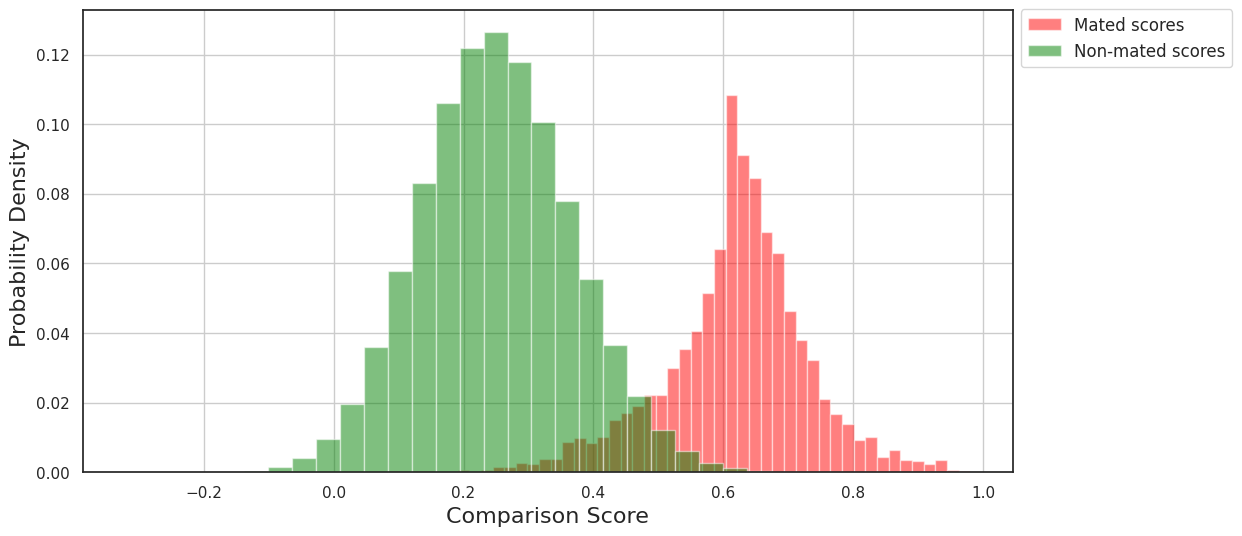

In [19]:

plot_histogram(mated_scores1, nonmated_scores1, normalise=True)


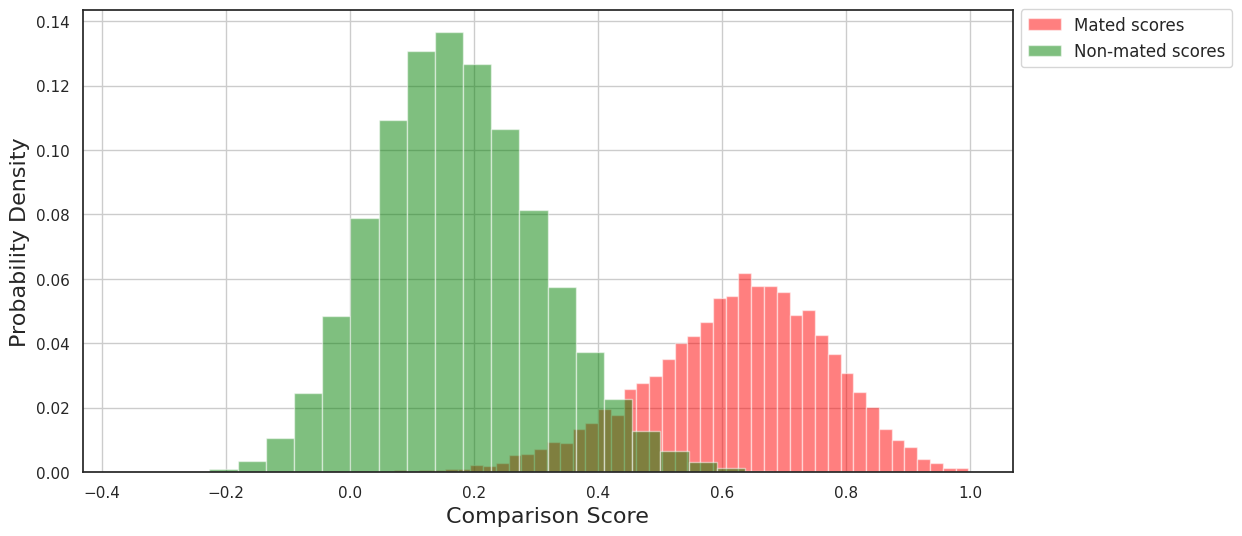

In [20]:
plot_histogram(mated_scores2, nonmated_scores2, normalise=True)


# Different thresholds 

In [ ]:
random_states = [1,2,3]
FNIR_c_list=[]
FNIR_a_list=[]
FPIR_c_list=[]
FPIR_a_list=[]
FPD_list=[]
FND_list=[]
GARBE_list=[]
threshold_list = []
# percentiles = np.arange(78, 100, 2)
percentile = 66

for random_state_i in random_states:

    ### Load children and adults balanced data ###
    children_balanced_df_i = balance_child_data(children_all, print_stats=False, random_state=random_state_i)
    adults_balanced_df_i = balance_adults_data_enrolled(children_balanced_df_i, adults_all, print_stats=False, random_state=random_state_i)



    ### All reference image names, enrolled and non-enrolled image names - children ###
    c_mates = children_balanced_df_i.groupby("identity_name").agg({'identity_name': ['count']})
    enrolled_identity_names_c = c_mates[c_mates[('identity_name', 'count')] > 1].index
    enrolled_image_names_c = list(children_balanced_df_i[children_balanced_df_i["identity_name"].isin(enrolled_identity_names_c)].image_name)
    non_enrolled_identity_names_c = c_mates[c_mates[('identity_name', 'count')] == 1].index
    non_enrolled_image_names_c = list(children_balanced_df_i[children_balanced_df_i["identity_name"].isin(non_enrolled_identity_names_c)].image_name)
    all_reference_image_names_c = list(children_balanced_df_i.image_name)


    ### All reference image names, enrolled and non-enrolled image names - adults ###
    a_mates = adults_balanced_df_i.groupby("identity_name").agg({'identity_name': ['count']})
    enrolled_identity_names_a = a_mates[a_mates[('identity_name', 'count')] > 1].index
    enrolled_image_names_a = list(adults_balanced_df_i[adults_balanced_df_i["identity_name"].isin(enrolled_identity_names_a)].image_name)
    non_enrolled_identity_names_a = a_mates[a_mates[('identity_name', 'count')] == 1].index
    non_enrolled_image_names_a = list(adults_balanced_df_i[adults_balanced_df_i["identity_name"].isin(non_enrolled_identity_names_a)].image_name)
    all_reference_image_names_a = list(adults_balanced_df_i.image_name)



    ### Similarity matrices for ids in reference database ###
    indices_c_all_reference = [image_names_c.index(name) for name in all_reference_image_names_c]
    indices_a_all_reference = [image_names_a.index(name) for name in all_reference_image_names_a]



    # Extract corresponding columns from the similarity matrix
    sim_mat_c_reference_cols = sim_mat_c[:, indices_c_all_reference]


    sim_mat_a_reference_cols = sim_mat_a[:, indices_a_all_reference]

    # Extract corresponding rows from the numerical ids
    num_ids_c_reference = num_ids_c[indices_c_all_reference]
    num_ids_a_reference = num_ids_a[indices_a_all_reference]


    ### Similarity matrices for non-enrolled ids ###
    # Get indices of all feature and numerical id elements that are non-enrolled  ids
    indices_c_non_enrolled = [image_names_c.index(name) for name in non_enrolled_image_names_c]
    indices_a_non_enrolled = [image_names_a.index(name) for name in non_enrolled_image_names_a]


    # Extract corresponding rows from the similarity matrix
    sim_mat_c_non_enrolled_0 = sim_mat_c_reference_cols[indices_c_non_enrolled]
    sim_mat_a_non_enrolled_0 = sim_mat_a_reference_cols[indices_a_non_enrolled]

    # Extract corresponding rows from the numerical ids
    num_ids_c_non_enrolled = num_ids_c[indices_c_non_enrolled]
    num_ids_a_non_enrolled = num_ids_a[indices_a_non_enrolled]


    ### Similarity matrices for enrolled ids ###
    # Get indices of all feature and numerical id elements that are enrolled ids
    indices_c_enrolled = [image_names_c.index(name) for name in enrolled_image_names_c]
    indices_a_enrolled = [image_names_a.index(name) for name in enrolled_image_names_a]

    # Extract corresponding rows from the similarity matrix
    sim_mat_c_enrolled_0 = sim_mat_c[np.ix_(indices_c_enrolled, indices_c_enrolled)] # only enrolled columns and rows
    sim_mat_a_enrolled_0 = sim_mat_a[np.ix_(indices_a_enrolled, indices_a_enrolled)]

    # Extract corresponding rows from the numerical ids
    num_ids_c_enrolled = num_ids_c[indices_c_enrolled]
    num_ids_a_enrolled = num_ids_a[indices_a_enrolled]


    ### DET THINGS ###

    thold = (np.percentile(sim_mat_c,percentile)+np.percentile(sim_mat_a,percentile))/2
    # thold = ((np.percentile(sim_mat_c_non_enrolled_0,percentile) + (np.percentile(sim_mat_a_non_enrolled_0,percentile)))/2 + (np.percentile(sim_mat_c_enrolled_0,percentile) + (np.percentile(sim_mat_a_enrolled_0,percentile)))/2 )/2
    # thold = np.percentile(sim_mat_a, 99)

    ### Evaluation metrics ###
    # FNIR
    FNIR_c, sim_mat_c_enrolled = compute_fnir(sim_mat_c_enrolled_0, sim_mat_c, enrolled_identity_names_c, num_ids_c_enrolled, ids_c, thold=thold)
    FNIR_a, sim_mat_a_enrolled = compute_fnir(sim_mat_a_enrolled_0, sim_mat_a, enrolled_identity_names_a, num_ids_a_enrolled, ids_a, thold=thold)
    # FPIR
    FPIR_c = compute_fpir(sim_mat_c_non_enrolled_0, num_ids_c_non_enrolled, num_ids_c_reference, thold=thold)
    FPIR_a = compute_fpir(sim_mat_a_non_enrolled_0, num_ids_a_non_enrolled, num_ids_a_reference, thold=thold)




    # OBS maybe compute Garbe outside funtion to choose a good alpha?
    alpha_garbe = 0.25
    FPD_i, FND_i, GARBE_i = GARBE(FNIR_c, FNIR_a, FPIR_c, FPIR_a, alpha=alpha_garbe)


    FNIR_c_list.append(FNIR_c)
    FNIR_a_list.append(FNIR_a)
    FPIR_c_list.append(FPIR_c)
    FPIR_a_list.append(FPIR_a)
    FPD_list.append(FPD_i)
    FND_list.append(FND_i)
    GARBE_list.append(GARBE_i)
    threshold_list.append(thold)

    print("done")

data = {
    'Iteration': random_states,
    'FNIR_c': FNIR_c_list,
    'FNIR_a': FNIR_a_list,
    'FPIR_c': FPIR_c_list,
    'FPIR_a': FPIR_a_list,
    'FPD': FPD_list,
    'FND': FND_list,
    'GARBE': GARBE_list,
    'Threshold': threshold_list
}


In [ ]:
df_all_threshold_66 = pd.DataFrame(data)

In [ ]:
data_threshold_plot = pd.concat([data_threshold_plot, df_all_threshold_66 ])

In [ ]:
data_threshold_plot

In [ ]:
data_threshold_plot.sort_values(by = 'Threshold')

In [ ]:
# group by threshold
plot_df = data_threshold_plot.groupby('Threshold').mean()

In [ ]:
plot_df

In [ ]:
plot_df.to_csv('magface_1_1_threshold_FNIR_plot.csv')

In [ ]:
# Plotting FNIR and FPIR vs. Threshold
plt.figure(figsize=(14, 7))

# Plot FNIR
plt.subplot(1, 2, 1)
plt.plot(plot_df.index, plot_df['FNIR_c'], 'r-', label='Children')
plt.plot(plot_df.index, plot_df['FNIR_a'], 'c-', label='Adults')
# plt.yscale('log')
plt.xlabel('Threshold')
plt.ylabel('FNIR')
plt.title('FNIR vs Threshold')
plt.legend()

# Plot FPIR
plt.subplot(1, 2, 2)
plt.plot(plot_df.index, plot_df['FPIR_c'], 'r-', label='Children')
plt.plot(plot_df.index, plot_df['FPIR_a'], 'c-', label='Adults')
# plt.yscale('log')
plt.xlabel('Threshold')
plt.ylabel('FPIR')
plt.title('FPIR vs Threshold')
plt.legend()

plt.tight_layout()
plt.show()


decide that an FNIR of 0.05 hence 5% is acceptable. 


# DET curves

In [ ]:
from DET_utils.DET_plots import *
from DET_utils.DET import *

In [ ]:
mated_kde, mated_pos, mated_min, mated_max = get_kde(mated_scores1)
nonmated_kde, nonmated_pos, nonmated_min, nonmated_max = get_kde(nonmated_scores1)
plt.figure(figsize=figure_size)
plt.plot(mated_pos, mated_kde(mated_pos), linewidth=linewidth, color=mated_colour, label=mated_label)
plt.plot(nonmated_pos, nonmated_kde(nonmated_pos), linewidth=linewidth, color=nonmated_colour, label=nonmated_label)
plt.xlabel("Score", size=label_fontsize)
plt.ylabel("Probability Density", size=label_fontsize)
plt.grid(True)
plt.legend(loc=legend_loc, bbox_to_anchor=legend_anchor, ncol=legend_cols, fontsize=legend_fontsize)
plt.show()

In [ ]:
d_prime_system1 = d_prime(mated_scores1, nonmated_scores1)
print("d' child =", round(d_prime_system1, round_digits))

d_prime_system2 = d_prime(mated_scores2, nonmated_scores2)
print("d' adult =", round(d_prime_system2, round_digits))

# d_prime_system3 = d_prime(mated_scores3, nonmated_scores3)
# print("d' canonical =", round(d_prime_system3, round_digits))


In [ ]:
threshold1 = 0.31
kde_with_threshold(mated_scores1, nonmated_scores1, scores_type1, threshold1)

In [ ]:
threshold2 = thold
kde_with_threshold(mated_scores2, nonmated_scores2, scores_type2, threshold2)

In [ ]:
det = DET(biometric_evaluation_type='identification', abbreviate_axes=True, plot_eer_line=True, plot_title="Children vs adults")
det.x_limits = np.array([1e-4, .5])
det.y_limits = np.array([1e-4, .5])
det.x_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.x_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
det.y_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.y_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
det.create_figure()
det.plot(tar=adjust_scores_for_DET(mated_scores1, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label=system_name1)
det.plot(tar=adjust_scores_for_DET(mated_scores2, scores_type2), non=adjust_scores_for_DET(nonmated_scores2, scores_type2), label=system_name2)
det.legend_on(loc="upper right")
det.show()